In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
L = 50    # Kantenlänge der 1D-"Box" in Angstrom
T5 = 5    # Temperatur in K.
T40 = 40    # Temperatur in K.
T80 = 80    # Temperatur in K.
tf = 20        # Zielzeit der Integration in ps
tau = 0.01     # Schrittweite
abst = 3.265*(2**(1/6))  #Abstand der Teilchen von einander, Lennard-Jones-Kraft bei 2^(1/6)*sigma(O-O) gleich null

N = 2 # Teilchenzahl
x = np.array([0, 0+abst]) #Anfangspositionen
m = 16*np.ones(N) # beide Teilchen sind O-Atome.
Z = 8*np.ones(N,dtype=int) # beide Teilchen sind O-Atome.
vx5 = np.sqrt(T5/m)  #Geschwindigkeit für T = 5K
vx40 = np.sqrt(T40/m) #Geschwindigkeit für T = 40K
vx80 = np.sqrt(T80/m) #Geschwindigkeit für T = 80K

In [4]:
def LJkraft1D(x,Z,periodic=0,Lx=25):
    # Wir extrahieren die Anzahl der Teilchen und allokieren Matrizen für die
    # x- Komponente der Kraft:
    N=x.shape[0]
    fx=np.zeros(N) 
      
    # Die sigma-Matrix und epsk-Matrix beinhalten die Interaktionen für
    # Elemente untereinander. Wir verwenden einfach die Werte für Argon für
    # jede mögliche Interaktion, und passen diese für diejenigen Interaktionen
    # an, die wir wissen:
    sigMatrix  = 3.405*np.ones((103,103))
    epskMatrix = 119.8*np.ones((103,103))
    epskMatrix[2,2] = 10.9   
    sigMatrix[2,2] = 2.640 # He-He
    epskMatrix[8,8] = 72.2   
    sigMatrix[8,8] = 3.265 # O-O
    epskMatrix[2,8] = 28.0
    sigMatrix[2,8] = 2.952 # He-O
    epskMatrix[8,2] = epskMatrix[2,8]
    sigMatrix[8,2] = sigMatrix[2,8]  # He-O = O-He
    epskMatrix[18,8] = 93.0   
    sigMatrix[18,8] = 3.335 # Ar-O
    epskMatrix[8,18] = epskMatrix[18,8]   
    sigMatrix[8,18] = sigMatrix[18,8]  # Ar-O = O-Ar
    # Wir generieren auch Werte für Ar-He (Mittelwert von He-He und Ar-Ar):
    epskMatrix[2,18] = 0.5*(epskMatrix[2,2]+epskMatrix[18,18]) # He-Ar
    sigMatrix[2,18]  = 0.5*(sigMatrix[2,2]+sigMatrix[18,18]) # He-Ar
    epskMatrix[18,2] = epskMatrix[2,18]
    sigMatrix[18,2] = sigMatrix[2,18]  # Ar-He = He-Ar

    # Jetzt loopen wir über Paare von verschiedenen Teilchen. Indem wir nur
    # Paare mit i<j betrachten, sorgen wir dafür, dass jedes Paar 1 mal dran ist:
    for i in range(0,N-1):
        for j in range(i+1,N):
            # Wenn periodic=0, dann liefern diese beiden loops einfach nur
            # offsX = 0 und offsY = 0. Wenn periodic = 1, dann loopen wir hier
            # über 9 benachbarte Zellen und berücksichtigen somit auch die 
            # Krafteinwirkung der Atome in jeder dieser Zellen:
            for offsX in range(-periodic,periodic+1):
                for offsY in range(-periodic,periodic+1):
                    xij  = x[j]+Lx*offsX-x[i];
                    sig2 = sigMatrix[Z[i],Z[j]]**2
                    r2=xij**2 # Abstand^2
                    
                    # fac=4*epsk*(12/r^14-6/r^8):
                    if (r2< 1):
                        r2 = 1
                        #print("sig2 = ",sig2,"r2=",r2,i,j,offsX,offsY)
                    
                    ri2=sig2/r2
                    LJfaktor=24.0*epskMatrix[Z[i],Z[j]]*(ri2**4)*(2.0*(ri2**3)-1.0)/sig2 
                    fx[i] -= xij*LJfaktor # Beitrag dieser Paarkraft AUF i
                    fx[j] += xij*LJfaktor # Beitrag dieser Paarkraft AUF j
    

    return fx

In [5]:
def leapfrog1D(x,T,Z,m,Lx,tau,nstep,periodic):

    # Die Teilchenzahl ist einfach die Länge eines der input Vektoren
    N=x.shape[0] # Teilchenzahl
    nstep = int(nstep)
    
    # Wir definieren auch die Matrizen, die die Evolution des Systems
    # Beschreiben. Um die Anfangsgeschwindigkeit zu bei t = tau/2 zu erhalten,
    # müssen wir um einen halben Zeitschritt vorwärts projizieren.
    X = np.zeros((N,nstep+1)) 
    VX= np.zeros((N,nstep+1)) 
    X[:,0]= x # Startwerte
    fx = LJkraft1D(x,Z,periodic,Lx)
    VX[:,0] = np.sqrt(T/m)+0.5*tau*fx/m 

    # Der Leapfrog Loop
    for n in range(0,nstep):
        X[:,n+1]=X[:,n]+tau*VX[:,n] # Orte: n*tau -> (n+1)*tau
        # Reflektieren am Rand der 2D Box:
        for i in range(0,N):
            if (Lx > 0):
                if (X[i,n+1]<0): 
                    X[i,n+1]= -X[i,n+1]
                    VX[i,n]=-VX[i,n]
                if (X[i,n+1]>Lx): 
                    X[i,n+1]=2*Lx-X[i,n+1] 
                    VX[i,n]=-VX[i,n]
        
        fx=LJkraft1D(X[:,n+1],Z,periodic,Lx)
        VX[:,n+1]=VX[:,n]+tau*fx/m  # Impulse: (n+1/2)*tau -> (n+3/2)*tau

    # Da die Geschwindigkeit am Ende für einen halben zeitschritt früher
    # berechnet wurde, als die Position, müssen wir diese noch einen
    # halben Zeitschritt weiter propagieren:
    fx=LJkraft1D(X[:,-1],Z,periodic,Lx)
    VX[:,-1]=VX[:,-1]-0.5*tau*fx/m
    
    T1 = X[0,:] #Teilchen 1: holt sich die gesamte erste Zeile aus der Matrix mit den Positionsdaten
    T2 = X[1,:] #Teilchen 2: holt sich die gesamte zweite Zeile

    nstep = np.round(tf/tau) # Anzahl Schritte
    t = np.linspace(0,tf,int(nstep+1)) #Festlegung der Zeitachse (0, Gesamtzeit, Anzahl Zeitschritte)
    
    return t, T1, T2

In [6]:
nstep = np.round(tf/tau)

#Aufrufen der leapfrog1D-Funktion, um die jeweiligen Bewegungsdaten der Teilchen zu erhalten
t, T1_5, T2_5 = leapfrog1D(x,T5,Z,m,L,tau,nstep,0) #für T=5K
t, T1_40, T2_40 = leapfrog1D(x,T40,Z,m,L,tau,nstep,0) #für T=40K
t, T1_80, T2_80 = leapfrog1D(x,T80,Z,m,L,tau,nstep,0) #für T=80K

In [7]:
#Berechnung des Abstandes der Teilchen
#Berechnung des Schwerpunktes der beiden Teilchen
dif5 = np.abs(T1_5-T2_5)
sp5 = (T1_5+T2_5)/2

dif40 = np.abs(T1_40-T2_40)
sp40 = (T1_40+T2_40)/2

dif80 = np.abs(T1_80-T2_80)
sp80 = (T1_80+T2_80)/2

Text(0.5, 0.98, 'Temperatur = 5 K')

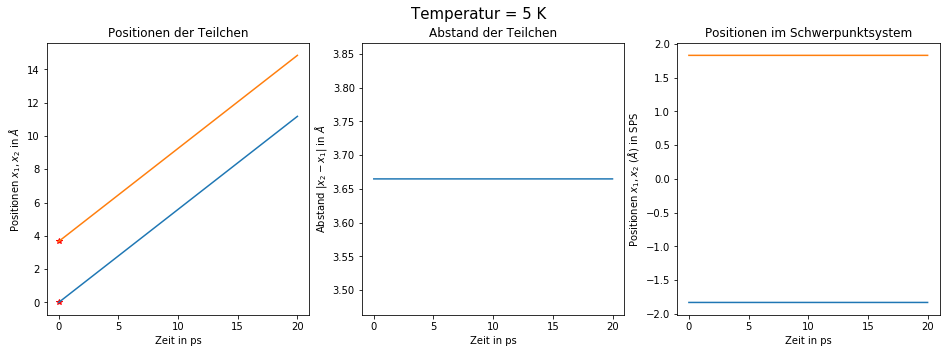

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(np.array([0,0]),x,'r*')
axs[0].plot(t, T1_5)
axs[0].plot(t, T2_5)
axs[0].set_title("Positionen der Teilchen")
axs[0].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ in $\AA$")
axs[1].plot(t, dif5)
axs[1].set_title("Abstand der Teilchen")
axs[1].set(xlabel="Zeit in ps", ylabel="Abstand $|x_2-x_1|$ in $\AA$")
axs[2].plot(t, T1_5-sp5)
axs[2].plot(t, T2_5-sp5)
axs[2].set_title("Positionen im Schwerpunktsystem")
axs[2].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ ($\AA$) in SPS")
fig.suptitle('Temperatur = 5 K', size=15)

Text(0.5, 0.98, 'Temperatur = 40 K')

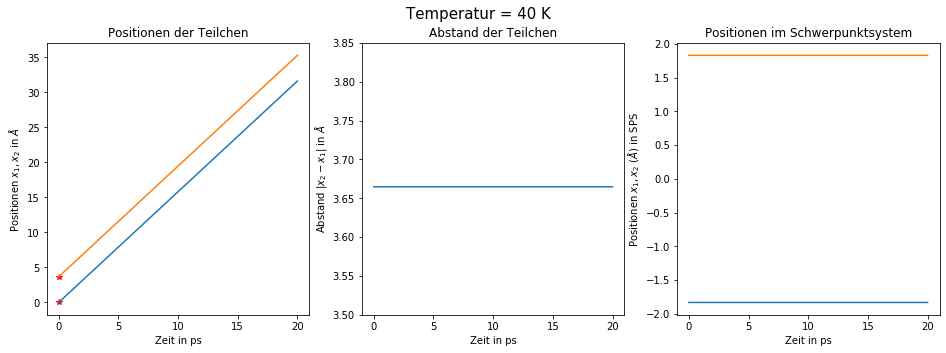

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(np.array([0,0]),x,'r*')
axs[0].plot(t, T1_40)
axs[0].plot(t, T2_40)
axs[0].set_title("Positionen der Teilchen")
axs[0].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ in $\AA$")
axs[1].plot(t, dif40)
axs[1].set_title("Abstand der Teilchen")
axs[1].set(xlabel="Zeit in ps", ylabel="Abstand $|x_2-x_1|$ in $\AA$")
axs[1].set_ylim(3.5,3.85)
axs[2].plot(t, T1_40-sp40)
axs[2].plot(t, T2_40-sp40)
axs[2].set_title("Positionen im Schwerpunktsystem")
axs[2].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ ($\AA$) in SPS")
fig.suptitle('Temperatur = 40 K', size=15)

Text(0.5, 0.98, 'Temperatur = 80 K')

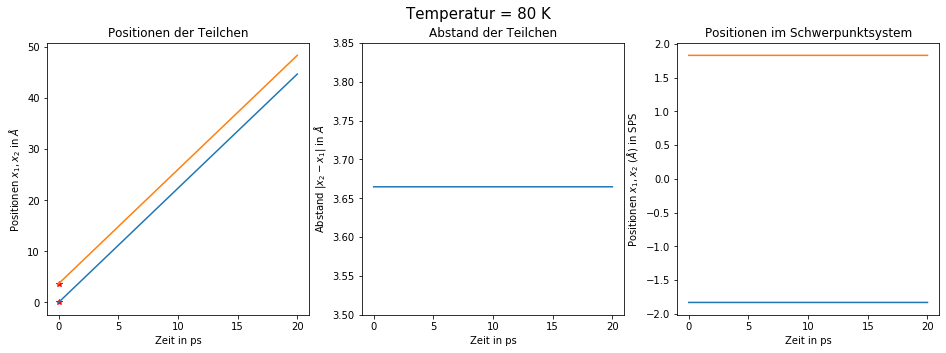

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(np.array([0,0]),x,'r*')
axs[0].plot(t, T1_80)
axs[0].plot(t, T2_80)
axs[0].set_title("Positionen der Teilchen")
axs[0].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ in $\AA$")
axs[1].plot(t, dif80)
axs[1].set_title("Abstand der Teilchen")
axs[1].set(xlabel="Zeit in ps", ylabel="Abstand $|x_2-x_1|$ in $\AA$")
axs[1].set_ylim(3.5,3.85)
axs[2].plot(t, T1_80-sp80)
axs[2].plot(t, T2_80-sp80)
axs[2].set_title("Positionen im Schwerpunktsystem")
axs[2].set(xlabel="Zeit in ps", ylabel="Positionen $x_1, x_2$ ($\AA$) in SPS")
fig.suptitle('Temperatur = 80 K', size=15)

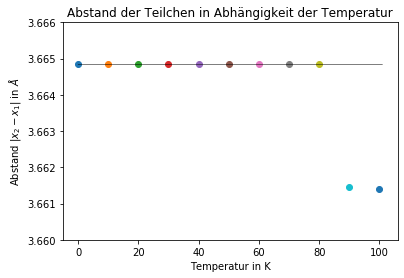

In [77]:
w = 3.265*(2**(1/6))*np.ones(10000)
for i in range(0,101,10):
    t, T1, T2 = leapfrog1D(x,i,Z,m,L,tau,nstep,0)
    mean_abst = np.mean(np.abs(T1-T2))
    plt.scatter(i, mean_abst, marker='o')
plt.plot(np.linspace(0,101,10000), w, linewidth=0.5, color='k')
plt.title("Abstand der Teilchen in Abhängigkeit der Temperatur")
plt.xlabel("Temperatur in K")
plt.ylabel("Abstand $|x_2-x_1|$ in $\AA$")
plt.ylim(3.660, 3.666)
plt.show()